## PLS
Model Pain single trials as a function of expectation rating, outcome rating, and stim intensity


fit it first. step wise regression
effect. weights. change
residuals. 
lowest possible estimate. 
depends on the statement.

In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [2]:
import h5py

In [3]:
def extract_metadata(filenames):
    pattern = re.compile(
        r"sub-(?P<sub>\d+)_"
        r"ses-(?P<ses>\d+)_"
        r"run-(?P<run>\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"trial-(?P<trial>\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimintensity>\w+)"
    )
    metadata_list = []
    for filename in filenames:
        match = pattern.search(filename)
        if match:
            metadata = match.groupdict()
            metadata_list.append(metadata)
    return pd.DataFrame(metadata_list)

In [4]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 1")
    plt.ylabel("Y comp. 1")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 2")
    plt.ylabel("Y comp. 2")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

## 0. load data

In [1]:
singletrial_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy"
task = "pain"

## 1. load_singletrial data from numpy DEP

## check metadata

# 1. load single trial data from nifti

In [7]:
import glob
from nilearn import image

# Replace 'your_directory_path' with the path to your NIfTI images
singletrial_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'
# file_pattern = 'your_directory_path/*.nii.gz' # or '*.nii' depending on your file format
flist = sorted(
    glob.glob(
        join(singletrial_dir, "sub-*", f"*runtype-{task}_event-*_cuetype-*.nii.gz"),
        recursive=True,
    )
)

# Check if you have the expected number of files
print(f"Found {len(flist)} NIfTI files.")

# Load the images (this might take some time depending on the size and number of files)
nifti_images = [image.load_img(f) for f in flist]

# Concatenate the images into a single 4D image
nifti_4d_image = image.concat_imgs(nifti_images)

# nifti_4d_image is now a 4D NIfTI image


Found 12048 NIfTI files.


In [8]:
nifti_4d_image.shape

(73, 86, 73, 12048)

## 2. apply mask to numpy array

In [10]:
imgfname = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/dartfs-hpc/rc/lab/C/CANlab/modules/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)

# 1) convert to 4d
# original_shape = mask_img.shape  # This should be the spatial shape of the brain volume
# array_4d = array_2d.reshape(original_shape + (-1,))

# # 2) apply masker
# affine = mask_img.affine  # Assuming your data shares the same space as the mask
# func_4d = nib.Nifti1Image(reordered_4d, affine)


# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

masked_func = nifti_masker.fit_transform(nifti_4d_image)
braindf = masked_func

In [11]:
braindf.shape

(12048, 98053)

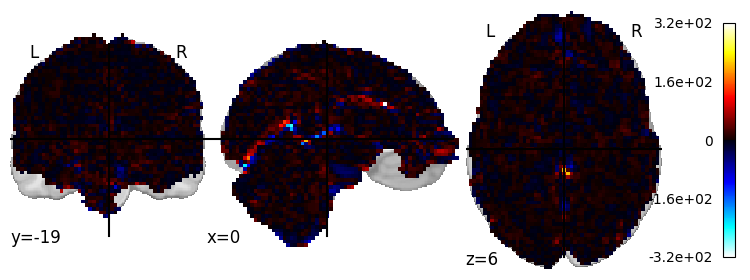

In [14]:
plotting.plot_stat_map(image.index_img(nifti_4d_image, 1))

## 3. for given brain data, find behavioral data

In [16]:
print("3. for given brain data, find behavioral data")
pattern = re.compile(r"sub-(\d+).*ses-(\d+).*run-(\d+)")
unique_combinations = set()  # Extract unique combinations using a set to store them
# flist = metadata['filelist']
for file in flist:
    match = pattern.search(file)
    if match:
        # Extract sub, ses, and run numbers and add to the set as a tuple
        unique_combinations.add(
            (int(match.group(1)), int(match.group(2)), int(match.group(3)))
        )
        
unique_combinations_list = sorted(list(unique_combinations))

# print(unique_combinations_list)

3. for given brain data, find behavioral data


In [17]:
unique_combinations_list[:6]

[(2, 3, 2), (2, 4, 3), (2, 4, 4), (3, 3, 3), (3, 3, 4), (3, 4, 2)]

## 4. load behavioral file

using identified metadata, load behavioral file

In [20]:
beh_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/beh/beh03_bids"  # "/Volumes/spacetop_projects_cue/data/beh/beh03_bids"
beh_dfs = []
for sub, ses, run in sorted(unique_combinations_list):
    beh_pattern = join(
        beh_dir,
        f"sub-{sub:04d}",
        f"ses-{ses:02d}",
        f"sub-{sub:04d}_ses-{ses:02d}_task-cue_*run-{run:02d}_runtype-*_events.tsv",
    )
    beh_files = glob.glob(beh_pattern)
    if beh_files:
        beh_fname = beh_files[0]
        bdf = pd.read_csv(
            beh_fname, sep="\t"
        )  # Make sure to use the correct separator, e.g., '\t' for TSV files
        beh_dfs.append(bdf)

stacked_df = pd.concat(beh_dfs, ignore_index=True)

# basenames = [os.path.basename(fpath) for fpath in flist]
# matching_rows = stacked_df[stacked_df['singletrial_fname'].isin(basenames)]


basenames = [os.path.basename(fpath).replace(".nii.gz", "") for fpath in flist]
# Remove the '.nii.gz' extension from 'singletrial_fname' in the DataFrame
stacked_df["singletrial_fname_no_ext"] = stacked_df["singletrial_fname"].str.replace(
    ".nii.gz", "", regex=False
)
# Now, find the rows in the DataFrame where singletrial_fname_no_ext matches the basenames without extension
intersection_beh = stacked_df[stacked_df["singletrial_fname_no_ext"].isin(basenames)]


In [21]:
intersection_beh.head()

,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext
0,10.57958,1.0,cue,sub-0002,ses-03,run-02,pain,cue,0,low_cue,low_stim,38.118276,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
1,35.68895,1.0,cue,sub-0002,ses-03,run-02,pain,cue,1,low_cue,med_stim,25.523425,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
2,61.28182,1.0,cue,sub-0002,ses-03,run-02,pain,cue,2,low_cue,low_stim,60.284232,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
3,91.27634,1.0,cue,sub-0002,ses-03,run-02,pain,cue,3,low_cue,high_stim,37.106656,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
4,119.98705,1.0,cue,sub-0002,ses-03,run-02,pain,cue,4,high_cue,med_stim,113.892502,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...


## 5. merge brain and behavioral data
ensure nifti file and behaviora data merge

In [22]:
print("5. merge brain and behavioral data")
import os
import pandas as pd

# Assuming 'df' is your existing DataFrame with a 'singletrial_fname' column
# And 'flist' is your list of file paths
# 1) Remove the '.npy' extension and sort the list
# 2) Create a DataFrame from sorted basenames
# 3) Remove the '.nii.gz' extension from 'singletrial_fname' and sort the DataFrame
sorted_basenames = sorted(os.path.basename(f).replace(".nii.gz", "") for f in flist)
basenames_df = pd.DataFrame(sorted_basenames, columns=["basename"])
stacked_df["basename"] = stacked_df["singletrial_fname"].str.replace(
    ".nii.gz", "", regex=False
)
sorted_df = stacked_df.sort_values(by="basename").reset_index(drop=True)

# Merge the two DataFrames based on the basename to ensure the order is the same
merged_df = pd.merge(basenames_df, sorted_df, on="basename", how="left")
print(merged_df)

5. merge brain and behavioral data
                                                basename      onset  duration  \
0      sub-0002_ses-03_run-02_runtype-pain_event-cue_...   10.57958       1.0   
1      sub-0002_ses-03_run-02_runtype-pain_event-cue_...   35.68895       1.0   
2      sub-0002_ses-03_run-02_runtype-pain_event-cue_...   61.28182       1.0   
3      sub-0002_ses-03_run-02_runtype-pain_event-cue_...   91.27634       1.0   
4      sub-0002_ses-03_run-02_runtype-pain_event-cue_...  119.98705       1.0   
...                                                  ...        ...       ...   
12043  sub-0133_ses-04_run-05_runtype-pain_event-stim...  245.44718       5.0   
12044  sub-0133_ses-04_run-05_runtype-pain_event-stim...  278.22461       5.0   
12045  sub-0133_ses-04_run-05_runtype-pain_event-stim...  317.62584       5.0   
12046  sub-0133_ses-04_run-05_runtype-pain_event-stim...  344.63184       5.0   
12047  sub-0133_ses-04_run-05_runtype-pain_event-stim...  383.23379       

In [23]:
merged_df["stim_con"] = merged_df["stimtype"].replace(
    {"high_stim": 1, "med_stim": 0, "low_stim": -1}
)

In [24]:
assert len(braindf) == len(
    merged_df
), "The matrix and dataframe must have the same number of rows"
# Create a new column in 'merged_df' that uniquely identifies each session
merged_df["session_id"] = (
    merged_df[["sub", "ses", "run"]].astype(str).agg("_".join, axis=1)
)

# Prepare an array to hold the z-scored brain data
zscored_braindf = np.empty_like(braindf)
# Assuming 'run_id' is a column in 'merged_df' that uniquely identifies each run
# and 'braindf' is a pandas DataFrame with the same index as 'merged_df'
# Create an array to hold the column means for each run
column_means_per_run = np.zeros_like(braindf)
session_ids = merged_df["session_id"].unique()

# Calculate the column means for each run and fill NaN values
for session_id in session_ids:
    indices = np.where(merged_df["session_id"] == session_id)[
        0
    ]  # Get the indices for the current run
    column_means = np.nanmean(
        braindf[indices], axis=0
    )  # Calculate the mean of each column for the current run, ignoring NaNs
    # If a whole column is NaNs, fill it with zeros or a global mean if preferred
    column_means = np.nan_to_num(
        column_means, nan=0.0
    )  # or replace 0.0 with a global mean
    # Assign the means to the corresponding places in the column means array
    column_means_per_run[indices] = column_means
# Where braindf is NaN, fill in the values from column_means_per_run
braindf_filled = np.where(np.isnan(braindf), column_means_per_run, braindf)

In [25]:
braindf_filled.shape

(12048, 98053)

## grab numpy data and plot

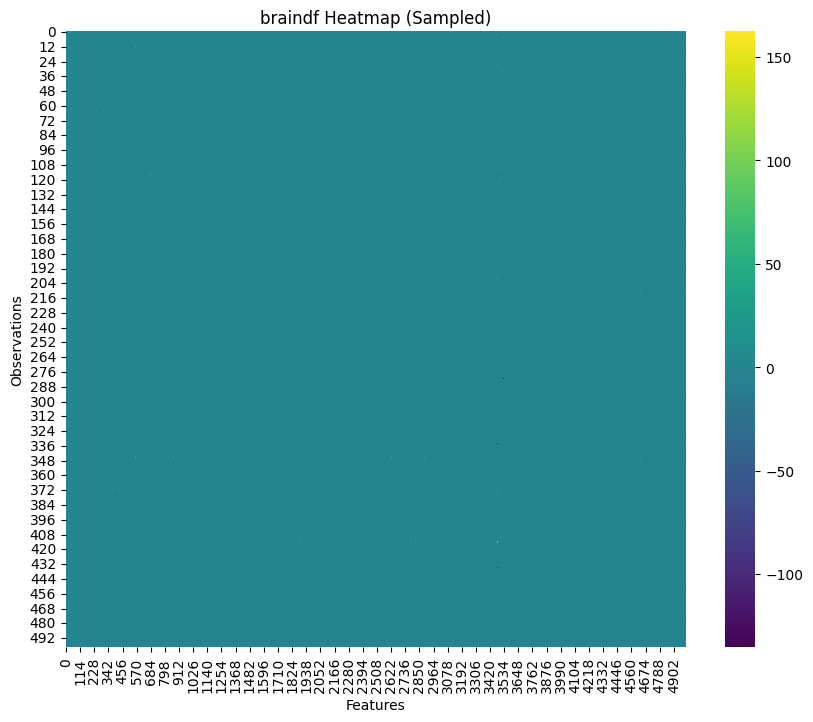

In [61]:
flattened_1 = array_2d.reshape((6227, -1))

# Assuming braindf_filled is a NumPy array
n_rows, n_cols = flattened_1.shape

# Number of rows and columns to sample
sample_size_rows = 500  # Adjust as needed
sample_size_cols = 5000  # Adjust as needed

# Randomly choose indices
rows_indices = np.random.choice(n_rows, sample_size_rows, replace=False)
cols_indices = np.random.choice(n_cols, sample_size_cols, replace=False)

# Sample the array
sampled_array = flattened_1[np.ix_(rows_indices, cols_indices)]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(sampled_array, cmap="viridis", cbar=True)
plt.title("braindf Heatmap (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## plot brain data

Text(95.72222222222221, 0.5, 'Observations')

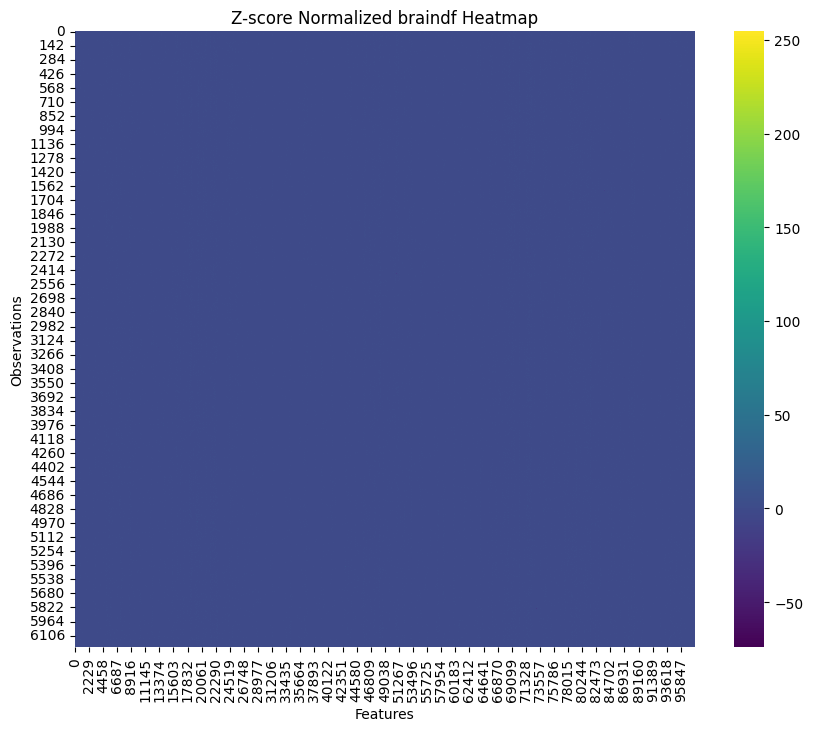

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(braindf, cmap="viridis", cbar=True)
plt.title("Z-score Normalized braindf Heatmap")
plt.xlabel("Features")
plt.ylabel("Observations")

In [48]:
braindf.shape

(6227, 98053)

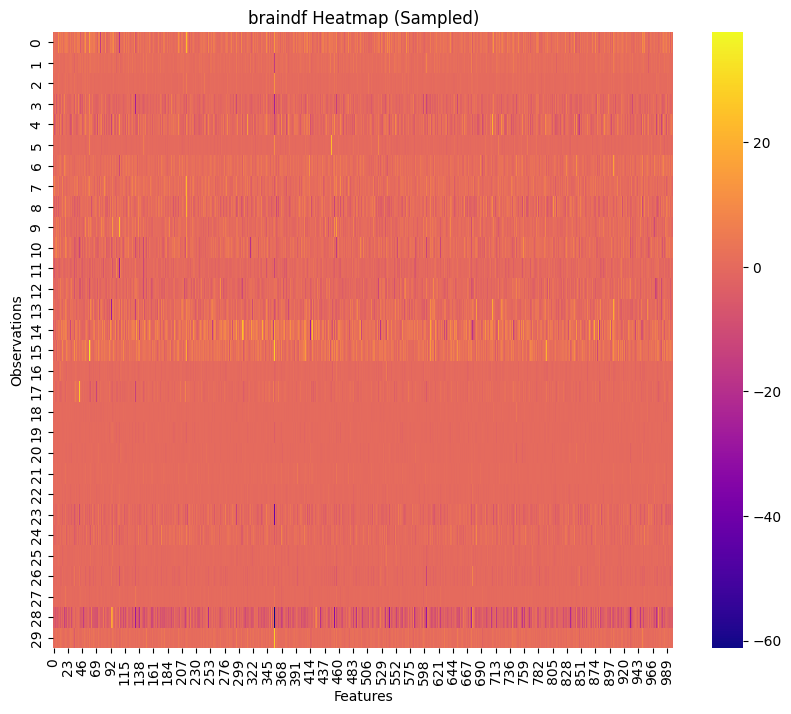

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming braindf_filled is a NumPy array
n_rows, n_cols = braindf.shape

# Number of rows and columns to sample
sample_size_rows = 30  # Adjust as needed
sample_size_cols = 1000  # Adjust as needed

# Randomly choose indices
rows_indices = np.random.choice(n_rows, sample_size_rows, replace=False)
cols_indices = np.random.choice(n_cols, sample_size_cols, replace=False)

# Sample the array
sampled_array = braindf[np.ix_(rows_indices, cols_indices)]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(sampled_array, cmap="plasma", cbar=True)
plt.title("braindf Heatmap (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


In [32]:
Xinterim = merged_df[
    ["stim_con", "expectrating", "outcomerating"]
]  # stacked_dataframe#df #np.random.randn(89, 49000)  # Replace with your actual data
Yinterim = braindf  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data
# identify groups
from collections import Counter

subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(subject_ids)  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(subject_ids)
groupsinterim = (
    factorized_ids + 1
) 

In [33]:
Xinterim.shape

(12048, 3)

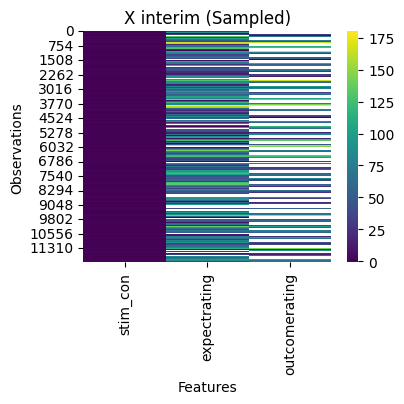

In [34]:

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(Xinterim, cmap="viridis", cbar=True)
plt.title("X interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


### TODO: normalize expect rating and outcome rating within participants

In [36]:
merged_df.head()

,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext,stim_con,session_id
0,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,10.57958,1.0,cue,sub-0002,ses-03,run-02,pain,cue,0,low_cue,low_stim,38.118276,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,-1,sub-0002_ses-03_run-02
1,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,35.68895,1.0,cue,sub-0002,ses-03,run-02,pain,cue,1,low_cue,med_stim,25.523425,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,0,sub-0002_ses-03_run-02
2,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,61.28182,1.0,cue,sub-0002,ses-03,run-02,pain,cue,2,low_cue,low_stim,60.284232,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,-1,sub-0002_ses-03_run-02
3,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,91.27634,1.0,cue,sub-0002,ses-03,run-02,pain,cue,3,low_cue,high_stim,37.106656,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,1,sub-0002_ses-03_run-02
4,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,119.98705,1.0,cue,sub-0002,ses-03,run-02,pain,cue,4,high_cue,med_stim,113.892502,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,0,sub-0002_ses-03_run-02


In [38]:
Xinterim

,stim_con,expectrating,outcomerating
0,-1,38.118276,NaN
1,0,25.523425,NaN
2,-1,60.284232,NaN
3,1,37.106656,NaN
4,0,113.892502,NaN
...,...,...,...
12043,1,34.520383,54.215477
12044,1,39.387797,67.132944
12045,0,69.268112,57.652557
12046,-1,64.566316,NaN


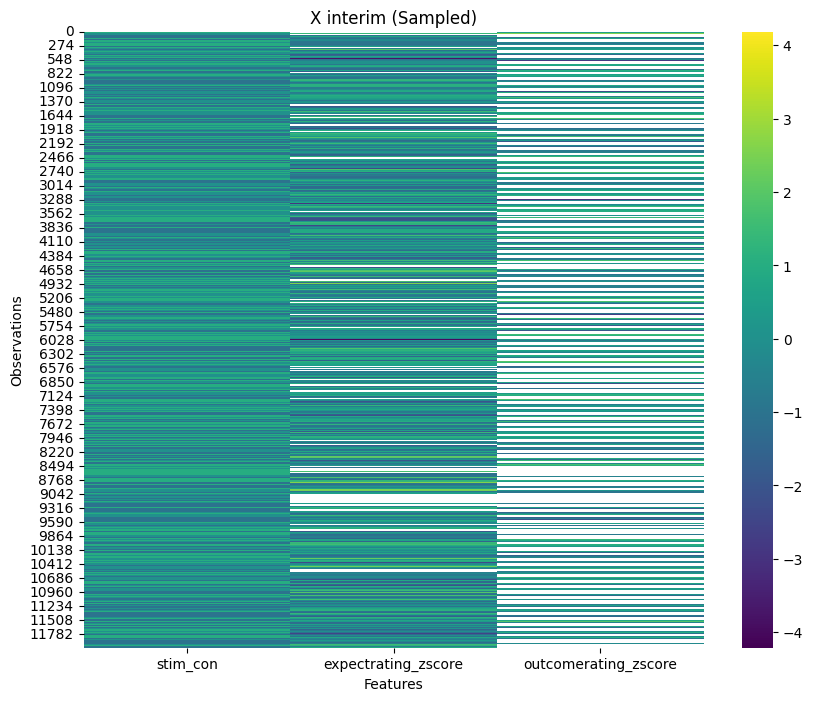

In [39]:
########################################################
# Z-score normalization for 'expect_rating' 'outcome_rating'
merged_df['expectrating_zscore'] = merged_df.groupby('sub')['expectrating'].transform(lambda x: (x - x.mean()) / x.std())
merged_df['outcomerating_zscore'] = merged_df.groupby('sub')['outcomerating'].transform(lambda x: (x - x.mean()) / x.std())

########################################################
# subset dataset
Xinterim = merged_df[
    ["stim_con", "expectrating_zscore", "outcomerating_zscore"]
]  # stacked_dataframe#df #np.random.randn(89, 49000)  # Replace with your actual data
# add intercept
# Xinterim.insert(0, 'intercept', 1)
# ones_column = np.ones((X_interim.shape[0], 1))  # Create a column of 1s with the same number of rows as X_interim
# Xinterim = np.hstack((ones_column, X_interim))
Yinterim = braindf  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data

########################################################
# identify groups
from collections import Counter

subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(subject_ids)  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(subject_ids)
groupsinterim = (
    factorized_ids + 1
) 


# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(Xinterim, cmap="viridis", cbar=True)
plt.title("X interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## 6. zscore matrix

## 7. remove nan values from X and Y

In [40]:
print("7. remove nan values from X and Y")
nan_rows = Xinterim.isnull().any(axis=1)
X = Xinterim[~nan_rows]
Y = Yinterim[~nan_rows]
merged_df[~nan_rows]
groups = groupsinterim[~nan_rows]
clean_indices = nan_rows[~nan_rows].index

# Assuming 'arr' is your NumPy array
# Calculate the mean of each row excluding NaN values
# arr = Y
row_means = np.nanmean(Y, axis=1)
inds = np.where(np.isnan(Y))  # Find the indices where NaN values are present
for i in range(len(inds[0])):  # Replace NaNs with the mean of the corresponding row
    Y[inds[0][i], inds[1][i]] = row_means[inds[0][i]]


7. remove nan values from X and Y


# 7-1.scree plot

In [ ]:
#define predictor and response variables
X = data[["mpg", "disp", "drat", "wt", "qsec"]]
y = data[["hp"]]

#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')

## 8. start PLS

In [41]:


outer_cv = GroupKFold(n_splits=5)
pls_model = PLSRegression(n_components=3)
i = 0
inner_scores = []
outer_scores = []
weights_per_fold = []
coefficients = []

# X = braindf
# Y = reg
for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    print(f"________________________________ fold {i} ________________________________")
    X_train, X_test = X.iloc[train_val_idx].to_numpy(), X.iloc[test_idx].to_numpy()
    Y_train, Y_test = Y[train_val_idx], Y[test_idx]
    groups_train_val = groups[train_val_idx]
    print(
        f"train participants: {np.unique(groups[train_val_idx])},test participants: {np.unique(groups[test_idx])}, "
    )
    # Fit the model
    pls_model.fit(X_train, Y_train)
    coefficients.append(pls_model.coef_)
    # Evaluate on the inner validation set
    Y_pred = pls_model.predict(X_test)
    inner_score = mean_squared_error(Y_test, Y_pred)
    inner_scores.append(inner_score)
    # Assuming the nifti_masker has been fitted previously
    y_weights = pls_model.y_weights_
    weights = pls_model.x_weights_
    weights_per_fold.append(weights)

    x_weights_first_component = pls_model.x_weights_[:, 0]
    y_weights_first_component = pls_model.y_weights_[:, 0]

    x_weights_second_component = pls_model.x_weights_[:, 1]
    y_weights_second_component = pls_model.y_weights_[:, 1]

    x_weights_third_component = pls_model.x_weights_[:, 2]
    y_weights_third_component = pls_model.y_weights_[:, 2]

#     first_img = nifti_masker.inverse_transform(x_weights_first_component)
#     second_img = nifti_masker.inverse_transform(x_weights_second_component)
#     third_img = nifti_masker.inverse_transform(x_weights_third_component)

________________________________ fold 0 ________________________________
train participants: [  1   2   3   4   5   6   7   8  10  12  14  15  16  18  19  20  21  23
  24  26  27  28  29  30  31  32  33  34  35  36  37  39  40  43  44  45
  46  47  49  50  51  52  53  54  55  56  58  59  60  61  62  63  64  66
  68  69  70  72  73  74  76  77  78  79  80  81  83  85  89  90  91  92
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 109],test participants: [  9  11  13  17  22  25  38  41  42  48  57  65  67  71  75  82  86  87
  88  93 108], 
________________________________ fold 1 ________________________________
train participants: [  2   4   5   6   7   8   9  10  11  12  13  16  17  18  19  20  22  24
  25  29  30  33  34  35  36  37  38  40  41  42  43  44  45  46  47  48
  49  50  51  53  54  56  57  58  59  60  61  62  63  64  65  67  69  70
  71  72  73  74  75  76  78  79  82  83  85  86  87  88  89  90  92  93
  94  95  96  97  98 100 101 102 103 104 106 107 108 109],te

# visualization


Presenting the results from a Partial Least Squares (PLS) regression involves several key aspects that help in interpreting and understanding the model. Here are some common ways to present and interpret the results:

1. Model Performance Metrics:
Present the overall performance of the model using metrics such as the Mean Squared Error (MSE), R-squared, or the prediction accuracy on a test set. This gives an idea of how well the model is performing.

2. Coefficient Weights:
Coefficients or weights in PLS indicate the importance of each feature in predicting the target variable. You can plot these weights to show which features have the most influence on the response variable.
A bar plot or a dot plot is often used to visualize these weights for each predictor.

3. Loadings Plots:
Loadings in PLS are similar to principal component analysis (PCA) and indicate how much each variable contributes to the components. A loadings plot can help understand the relationship between variables and the components.
Loadings plots are especially useful in PLS because they can show relationships both within and between the X (predictor) and Y (response) matrices.

4. Scores Plot:
A scores plot shows the projection of the samples into the space defined by PLS components. It can help to visualize the separation between different groups or clusters in your data.

5. Variable Importance in Projection (VIP):
The VIP score summarizes the importance of each variable in the PLS model. Variables with higher VIP scores are more important for the model.
A plot of VIP scores can be used to identify the most influential variables.

6. Cross-Validation Results:
If you performed cross-validation, present the variation of the performance metrics across different folds. This can demonstrate the stability and generalizability of the model.

7. Predictions vs Actual Plot:
A scatter plot of predicted vs actual values can be a good way to visually assess the model’s predictive power.

8. Residuals Analysis:
Plotting residuals (the difference between the observed and predicted values) can help to check for any patterns that might suggest problems with the model, such as non-linearity or heteroscedasticity.

9. Discussion of Results in Context:
It's important to discuss your findings in the context of the problem you're addressing. Explain what the results mean in practical terms and any implications or recommendations that can be drawn from the model.
When presenting these results, it's crucial to tailor your presentation to your audience. For a technical audience, you might delve into the details of the model and statistical analyses, while for a non-technical audience, focusing on the implications and high-level findings would be more effective. Remember that visualizations should be clear, well-labeled, and accompanied by explanations that make them accessible to your audience.

https://github.com/LeonieBorne/plstuto/blob/master/tutorials/introduction.ipynb

## scores

In [42]:
X_train_r, Y_train_r = pls_model.transform(X_train, Y_train)
X_test_r, Y_test_r = pls_model.transform(X_test, Y_test)

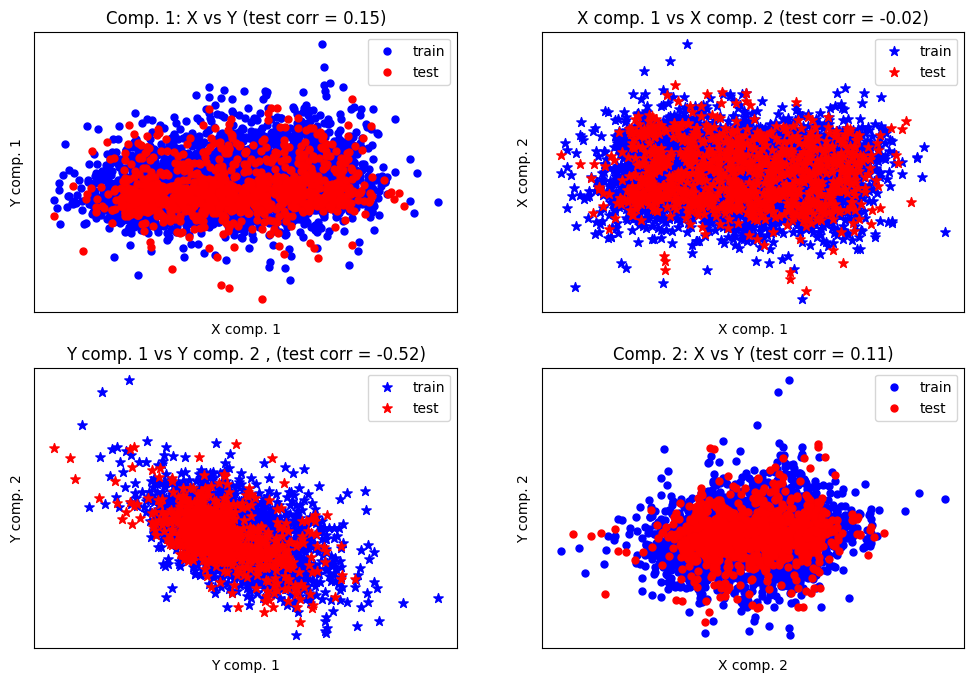

In [43]:
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

In [44]:
coefficients[0].shape

(3, 98053)

## loading plots

Text(0.5, 1.0, 'PLS Scores Plot')

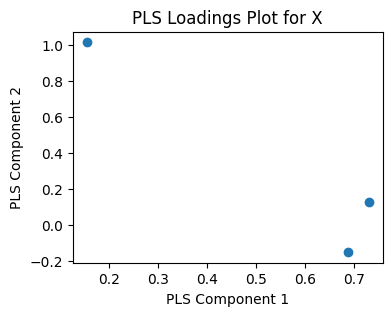

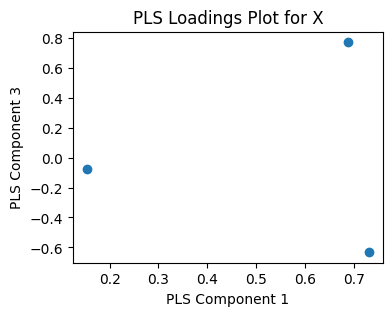

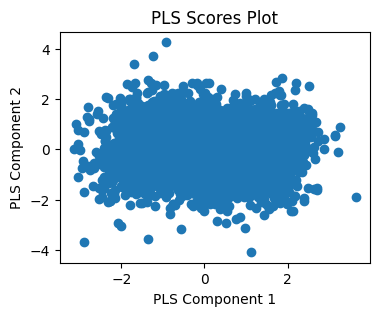

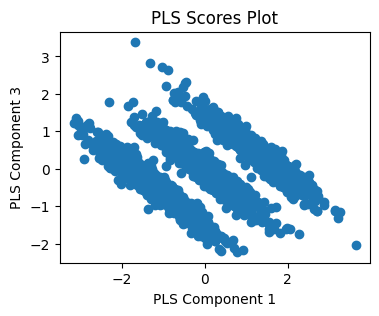

In [45]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assume X and Y are your data

# Fit the PLS model
# pls = PLSRegression(n_components=2)
# pls.fit(X, Y)

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()


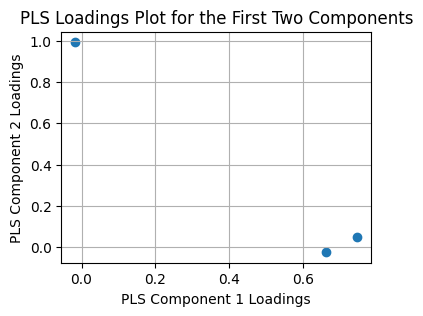

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `weights_per_fold` contains the x_weights for each fold
# Calculate the average weights across folds
avg_weights = np.mean(weights_per_fold, axis=0)

# Plotting the loadings for the first two components
plt.figure(figsize=(4,3))
plt.scatter(avg_weights[:, 0], avg_weights[:, 1])  # loadings on the first two components

# Optionally, label each point with its feature name
# for i, txt in enumerate(feature_names):
#     plt.annotate(txt, (avg_weights[i, 0], avg_weights[i, 1]))

plt.xlabel('PLS Component 1 Loadings')
plt.ylabel('PLS Component 2 Loadings')
plt.title('PLS Loadings Plot for the First Two Components')
plt.grid(True)
plt.show()


## 3d PLS score plot

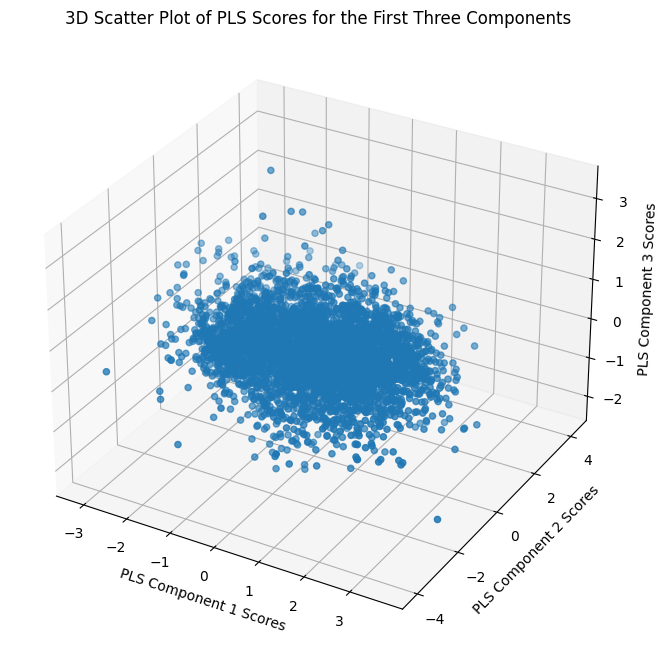

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `pls_model` is your fitted PLS model
X_scores = pls_model.x_scores_

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three components
ax.scatter(X_scores[:, 0], X_scores[:, 1], X_scores[:, 2])

ax.set_xlabel('PLS Component 1 Scores')
ax.set_ylabel('PLS Component 2 Scores')
ax.set_zlabel('PLS Component 3 Scores')
plt.title('3D Scatter Plot of PLS Scores for the First Three Components')

plt.show()


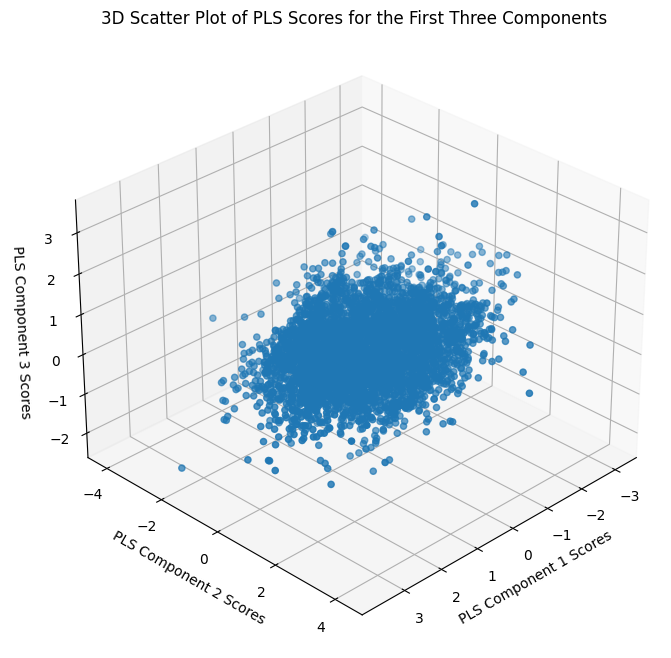

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `pls_model` is your fitted PLS model
X_scores = pls_model.x_scores_

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three components
ax.scatter(X_scores[:, 0], X_scores[:, 1], X_scores[:, 2])

ax.set_xlabel('PLS Component 1 Scores')
ax.set_ylabel('PLS Component 2 Scores')
ax.set_zlabel('PLS Component 3 Scores')
plt.title('3D Scatter Plot of PLS Scores for the First Three Components')

# Set viewing angle
elev = 30  # Use different angles for elevation
azim = 45  # Use different angles for azimuth
ax.view_init(elev=elev, azim=azim)

plt.show()


## VIP scores

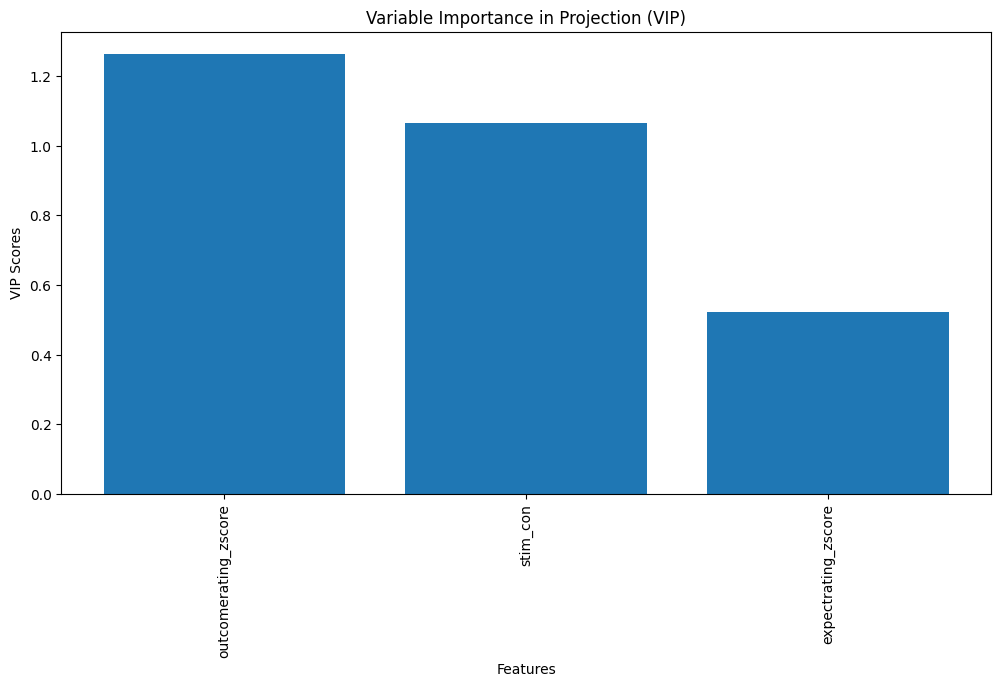

In [49]:
import numpy as np

def calculate_vip(model, X):
    t = model.x_scores_  # scores
    w = model.x_weights_  # weights
    q = model.y_loadings_  # y loadings

    p, h = w.shape
    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)

    return vips

import matplotlib.pyplot as plt

# Assuming `pls_model` is your fitted PLS model
vip_scores = calculate_vip(pls_model, X)

# Sort the VIP scores (and keep track of the feature names if you have them)
sorted_indices = np.argsort(vip_scores)[::-1]
sorted_vip_scores = vip_scores[sorted_indices]
feature_names = ["stim_con", "expectrating_zscore", "outcomerating_zscore"]
feature_names_sorted = np.array(feature_names)[sorted_indices]  # Replace feature_names with your actual feature names

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_vip_scores)), sorted_vip_scores, tick_label=feature_names_sorted)
plt.xlabel('Features')
plt.ylabel('VIP Scores')
plt.title('Variable Importance in Projection (VIP)')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.show()


In [50]:
sorted_vip_scores

array([1.26329243, 1.06362649, 0.52229391])

In [51]:
inner_scores

[0.9532567133912049,
 1.0958401640480282,
 0.9269167233127248,
 1.085667984530278,
 0.8048640460997838]

# betamaps

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `y_mean_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


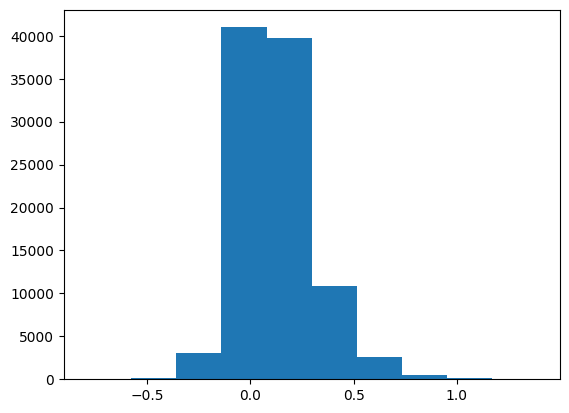

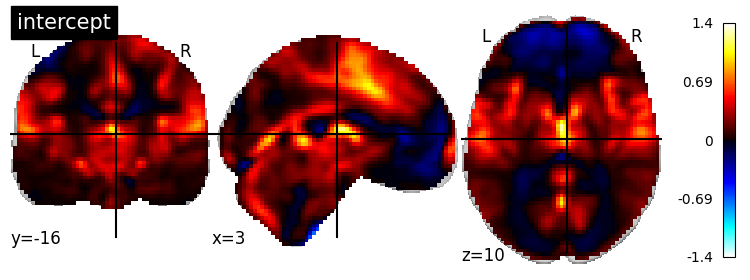

In [52]:
# https://stackoverflow.com/questions/41188410/how-obtain-the-intercept-of-the-pls-regression-sklearn
intercept = nifti_masker.inverse_transform(pls_model.y_mean_)
plt.hist(pls_model.y_mean_)
plotting.plot_stat_map(intercept,  title="intercept")

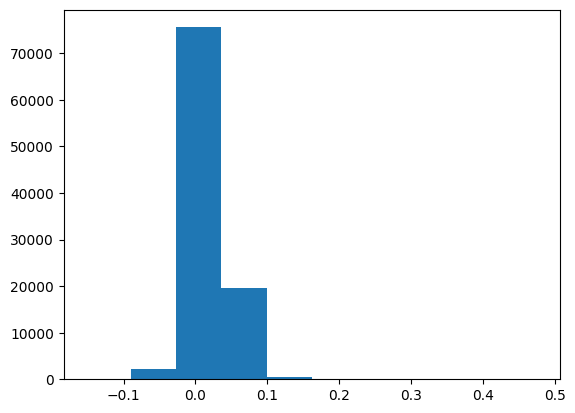

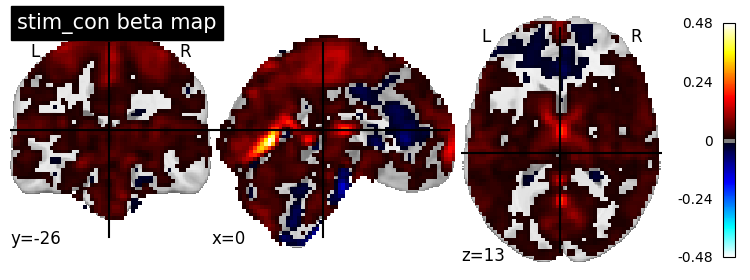

In [54]:
first_img_beta = nifti_masker.inverse_transform(coefficients[1][0,:])
plt.hist(coefficients[1][0,:])
plotting.plot_stat_map(first_img_beta, threshold=0.01, title="stim_con beta map")

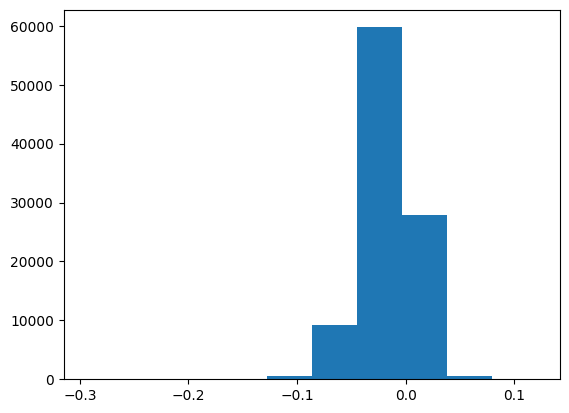

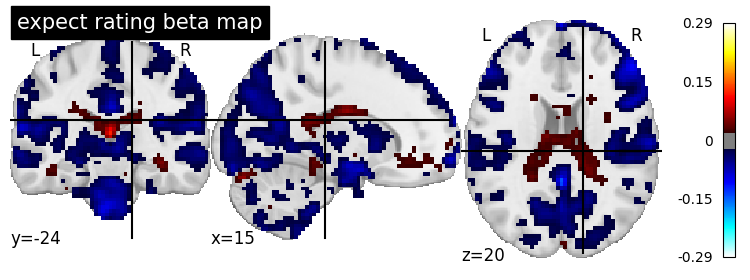

In [55]:
second_img_beta = nifti_masker.inverse_transform(coefficients[0][1,:])
plt.hist(coefficients[0][1,:])
plotting.plot_stat_map(second_img_beta, threshold=0.02, title="expect rating beta map")

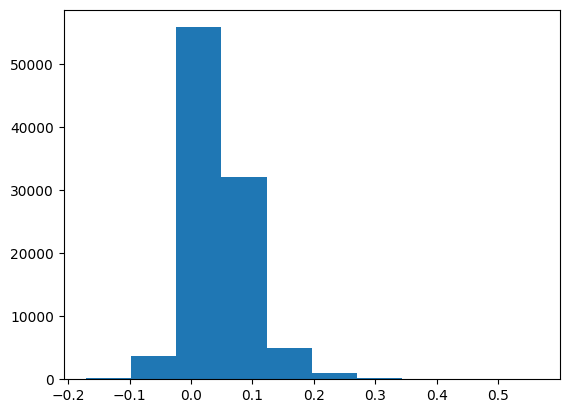

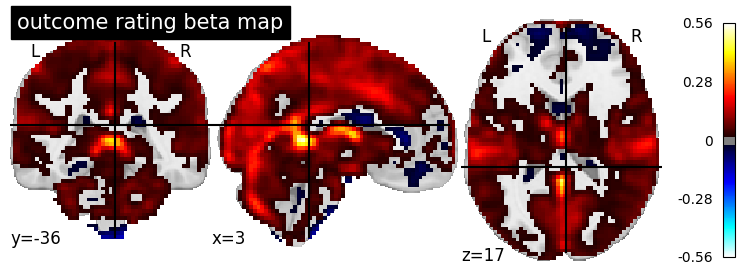

In [56]:
third_img_beta = nifti_masker.inverse_transform(coefficients[0][2,:])
plt.hist(coefficients[0][2,:])
plotting.plot_stat_map(third_img_beta, threshold=0.02, title="outcome rating beta map")

# weights

In [233]:
percentile_95

0.020541346844441886

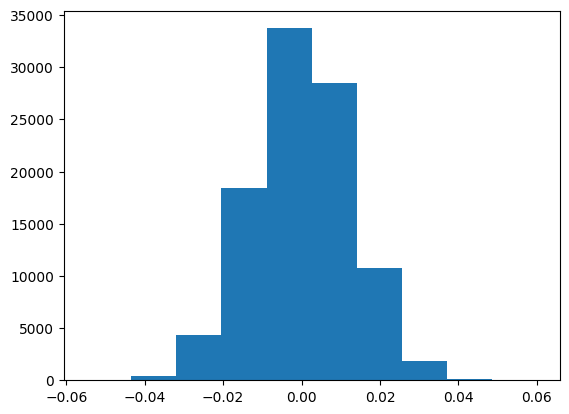

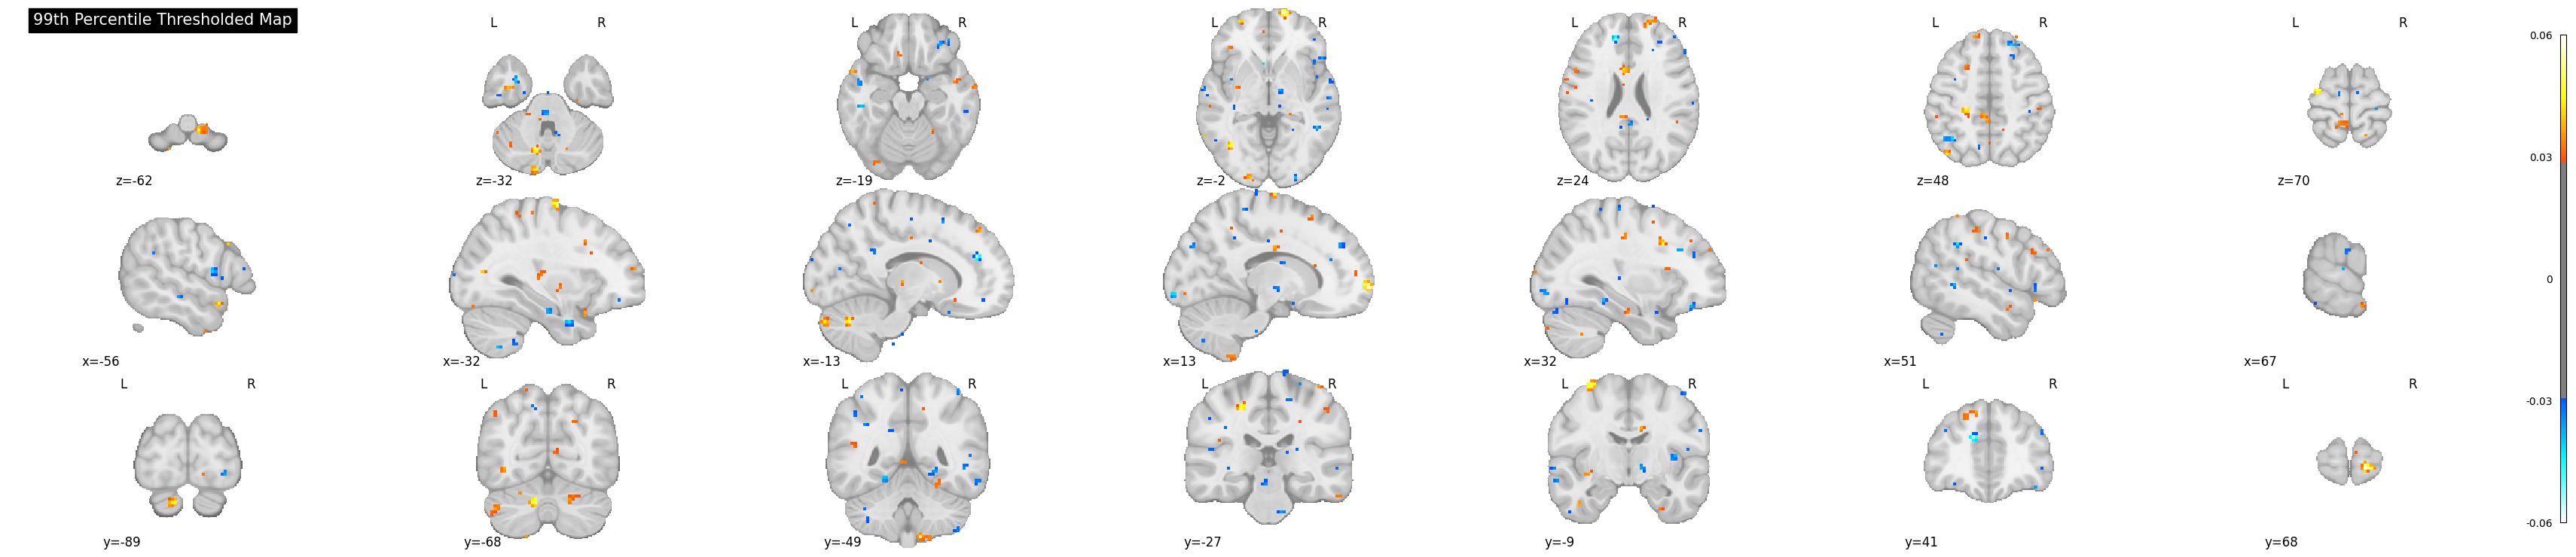

In [235]:
first_img = nifti_masker.inverse_transform(y_weights_first_component)
data = first_img.get_fdata()
percentile_99 = np.percentile(data[data != 0], 99)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_weights_first_component)
plotting.plot_stat_map(first_img, threshold=percentile_99, display_mode='mosaic', 
             title='99th Percentile Thresholded Map')

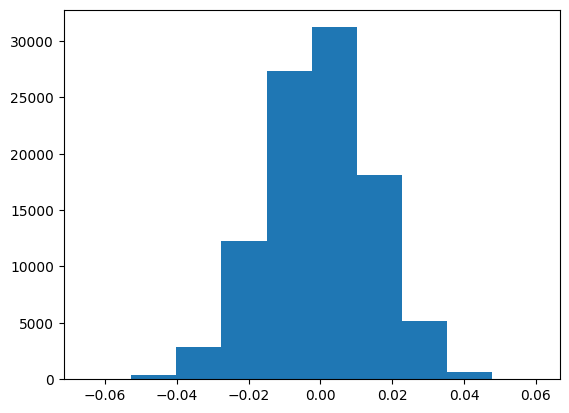

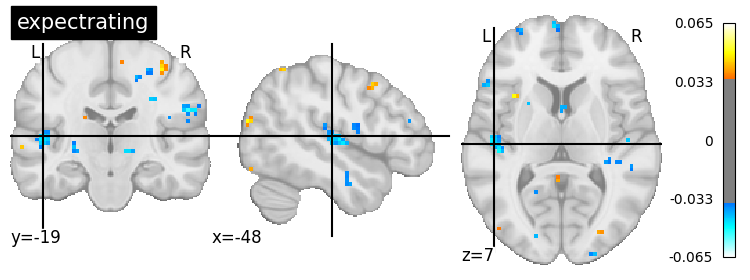

In [227]:
second_img = nifti_masker.inverse_transform(y_weights[:, 1])
plt.hist(y_weights[:, 1])
plotting.plot_stat_map(second_img, threshold=0.035, title="expectrating")

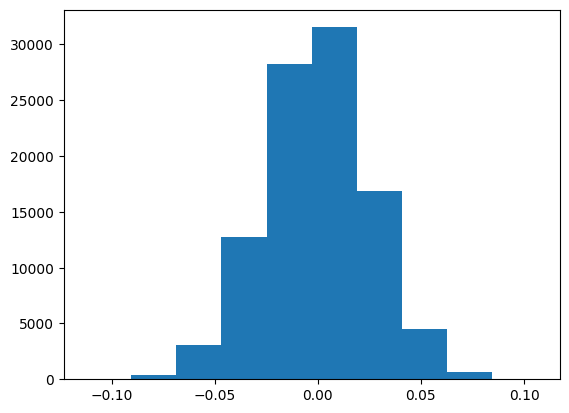

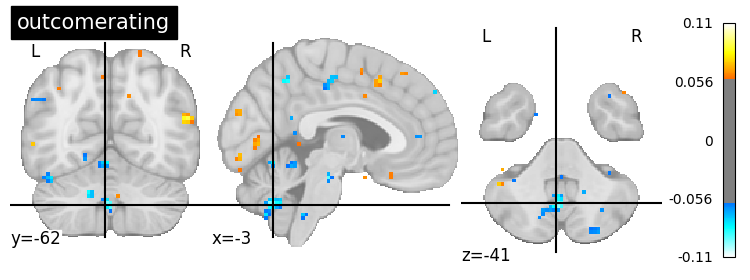

In [228]:
third_img = nifti_masker.inverse_transform(y_weights[:, 2])
plt.hist(y_weights[:, 2])
plotting.plot_stat_map(third_img, threshold=0.06, title="outcomerating")

# Y loadings



In Partial Least Squares (PLS) regression, the terms "loadings" and "weights" refer to different concepts, and they are not identical. Understanding the distinction is important for correctly interpreting the results of a PLS model.

**Y Loadings**
* What They Represent: Y loadings (often denoted as q in mathematical formulations) represent how the original Y variables (response variables) contribute to or are associated with the PLS components (latent variables). They essentially describe the relationship between the Y variables and each PLS component.
* Use in Visualization: In the context of neuroimaging or similar fields, Y loadings are often used to reconstruct the contribution of each voxel (or original feature in Y) to the PLS components. These loadings can be visualized as brain maps to understand which areas are most associated with the components.

**Y Weights**
* What They Represent: Y weights (often denoted as c in mathematical formulations) are used during the PLS algorithm to define the PLS components (latent variables) in relation to the Y variables. They are coefficients used to construct the PLS components from the original Y variables.
* Use in Model Construction: Weights are more about the internal mechanics of how PLS components are constructed. They're not typically used directly for post-modeling interpretation or visualization in the same way as loadings.

**Visualization in Neuroimaging**
* When visualizing results from a PLS model in a neuroimaging context, it's usually the loadings that are of interest, particularly if you're looking to understand how different brain regions (voxels) relate to the components derived from your predictors (X variables).
* The loadings can be transformed back into the spatial dimensions of the brain (e.g., using a NiftiMasker in nilearn) to create brain maps that show the contribution of each voxel to the PLS components.
In summary, while both loadings and weights are integral to the PLS algorithm and the interpretation of its results, they serve different roles. For visualization and understanding the contribution of original features (like brain voxels) to the model, you would typically use the Y loadings.

In [57]:
y_loadings = pls_model.y_loadings_


In [58]:
y_loadings.shape

(98053, 3)

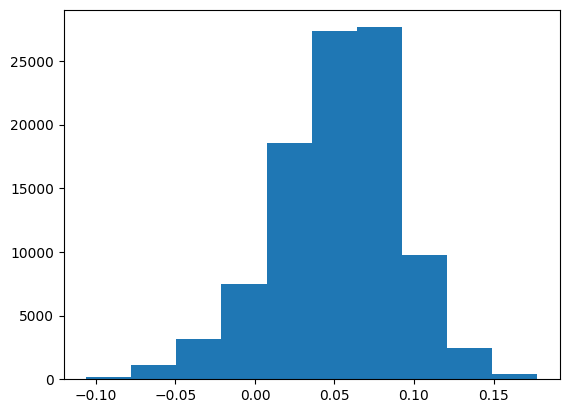

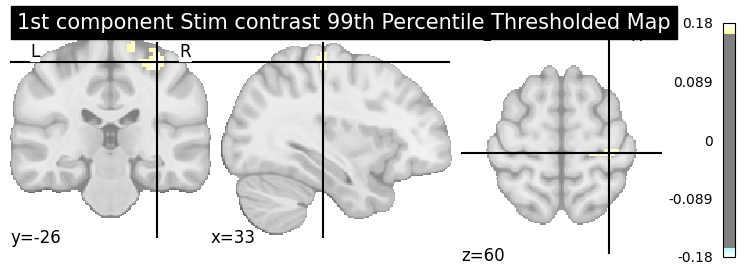

In [67]:
first_loadings = nifti_masker.inverse_transform(y_loadings[:,0])
data = first_loadings.get_fdata()
percentile_99 = np.percentile(data[data != 0], 99.9)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,0])
plotting.plot_stat_map(first_loadings, threshold=percentile_99, 
             title='1st component Stim contrast 99th Percentile Thresholded Map')

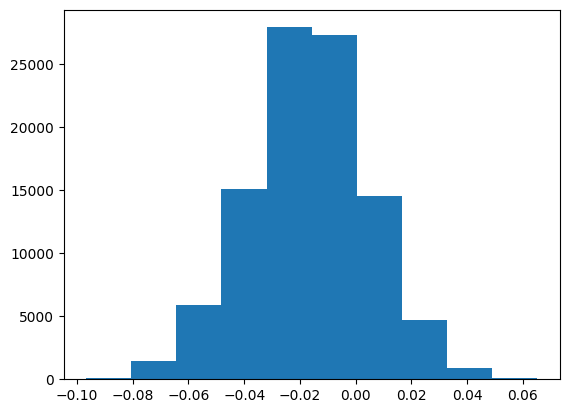

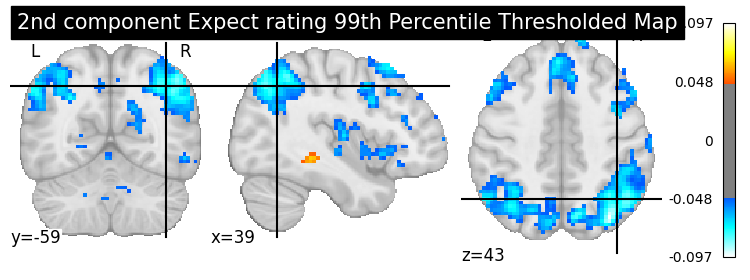

In [65]:
second_loadings = nifti_masker.inverse_transform(y_loadings[:,1])
data = second_loadings.get_fdata()
percentile_99 = np.percentile(data[data != 0], 99.9)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,1])
plotting.plot_stat_map(second_loadings, threshold=percentile_99, 
             title='2nd component Expect rating 99th Percentile Thresholded Map')

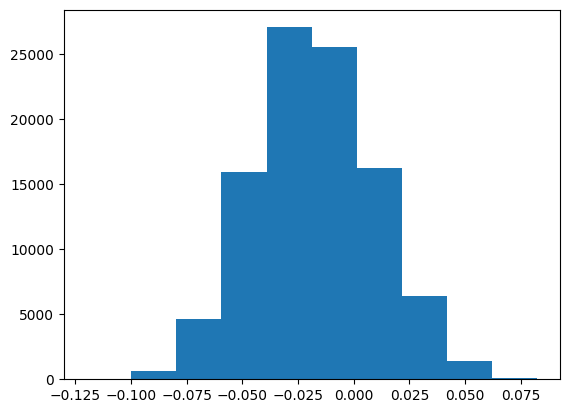

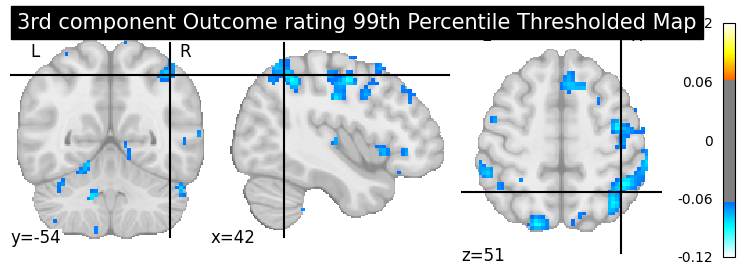

In [66]:
third_loadings = nifti_masker.inverse_transform(y_loadings[:,2])
data = third_loadings.get_fdata()
percentile_99 = np.percentile(data[data != 0], 99.9)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,2])
plotting.plot_stat_map(third_loadings, threshold=percentile_99, 
             title='3rd component Outcome rating 99th Percentile Thresholded Map')